In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
raw_data = pd.read_csv('DATASET.csv')
raw_data.head()

,event_id,session_id,user_id,variation,platform,datetime_event,event_type,final_order_status,shop_id
0,63527610,6391574,762832,2,Android,2024-11-30 16:23:46.391133804,entry_to_shop,successful,8531.0
1,12446736,6391574,762832,2,Android,2024-11-30 16:26:16.875713965,order_paid,successful,8531.0
2,90232698,6391574,762832,2,Android,2024-11-30 16:50:44.827088753,order_finished,successful,8531.0
3,74183469,9246026,762832,2,Android,2024-11-29 13:21:28.729203894,reload_the_page,NaN,6186.0
4,16360628,9246026,762832,2,Android,2024-11-29 13:21:35.213637901,entry_to_shop,NaN,6186.0


# Data Cleaning & EDA

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326921 entries, 0 to 326920
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   event_id            326921 non-null  int64  
 1   session_id          326921 non-null  int64  
 2   user_id             326921 non-null  int64  
 3   variation           326921 non-null  int64  
 4   platform            326921 non-null  object 
 5   datetime_event      326921 non-null  object 
 6   event_type          326921 non-null  object 
 7   final_order_status  170632 non-null  object 
 8   shop_id             315842 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 22.4+ MB


In [4]:
raw_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
event_id,326921.0,NaN,NaN,NaN,54971223.274348,26005727.141926,10000027.0,32451323.0,54919061.0,77504919.0,99999925.0
session_id,326921.0,NaN,NaN,NaN,5493266.772453,2598273.9833,1000058.0,3246170.0,5486265.0,7742072.0,9999979.0
user_id,326921.0,NaN,NaN,NaN,550159.16329,259722.459324,100003.0,325736.0,549509.0,775308.0,999985.0
variation,326921.0,NaN,NaN,NaN,1.349684,0.476871,1.0,1.0,1.0,2.0,2.0
platform,326921,2,Android,225929,NaN,NaN,NaN,NaN,NaN,NaN,NaN
datetime_event,326921,324699,2024-11-29 23:59:24.000000000,674,NaN,NaN,NaN,NaN,NaN,NaN,NaN
event_type,326921,4,entry_to_shop,168215,NaN,NaN,NaN,NaN,NaN,NaN,NaN
final_order_status,170632,3,successful,146035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shop_id,315842.0,NaN,NaN,NaN,5440.652238,2645.409437,1003.0,3150.0,5351.0,7801.0,9992.0


##### **Summary Statistics**

**Mean of 1.35** - Variation 1 (control) has 65% of the data. (65%/35%) split between control and test isn't exactly even - was this intentional or a randomization error? 

Most events 69% occured on **Android devices** - why such a skew to one device? Will need to keep this platform imbalance in mind. 

In [5]:
df = raw_data
df['datetime_event'] = pd.to_datetime(df['datetime_event'])
days = df['datetime_event'].dt.date.unique()
days.sort()
[print(day.strftime('%Y-%m-%d')) for day in days]

2024-11-25
2024-11-26
2024-11-27
2024-11-28
2024-11-29
2024-11-30
2024-12-01


[None, None, None, None, None, None, None]

## 1. Dates - The test period is Nov 25-30, 2024

- There's dates that are outside our testing period -> we need to clean this. 
- We also need to conside sessions that cross the boundaries of the test period is important for accuracy - so we'll do this first. 
    - i.e. person that starts a session before midnight (within the test period), but finishes their session outside the test period. 

In [6]:
# Test period boundaries
start_date = pd.Timestamp('2024-11-25')
end_date = pd.Timestamp('2024-11-30 23:59:59')

In [ ]:
# Find sessions that cross test boundaries
sessions_in_period = df[(df['datetime_event'] >= start_date) & (df['datetime_event'] <= end_date)]['session_id'].unique()
len(sessions_in_period)

179294

In [26]:
sessions_crossing_boundary = df[(df['datetime_event'] <= end_date) & (df.groupby('session_id')['datetime_event'].transform('max') > end_date)]['session_id'].unique()

# Get the all sessions that cross the boundary
cross_boundary_sessions = df[df['session_id'].isin(sessions_crossing_boundary)]
len(cross_boundary_sessions)

740

I will include these sessions in my analysis, since other days in the test had these similar users that crossed from one day to the next. We also need to consider: 

- Preserving the original experimental cohort
- Avoiding introduction of bias by arbitrarily removing sessions

### Checking for variation in sessions time during the day

In [27]:
# Check events per day by variation
daily_events = df.groupby([df['datetime_event'].dt.date, 'variation']).size().unstack()
print("Events per day by variation:")
print(daily_events)

Events per day by variation:
variation           1      2
datetime_event              
2024-11-25      23112  12199
2024-11-26      25376  13791
2024-11-27      25293  13875
2024-11-28      28054  14835
2024-11-29      63825  34030
2024-11-30      46703  25460
2024-12-01        239    129


<Figure size 1200x600 with 0 Axes>

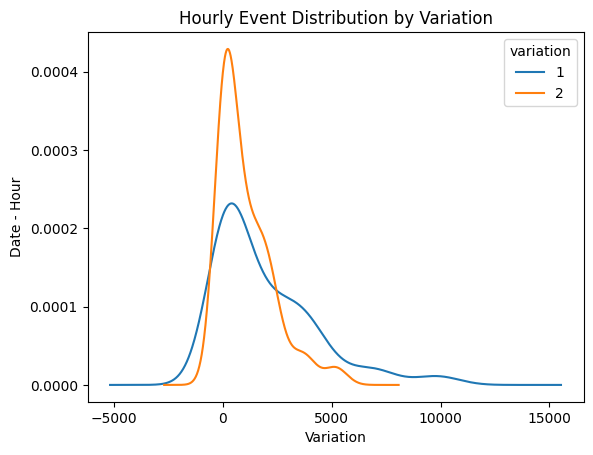

In [28]:
# Check for gaps - count hourly events to identify potential collection issues
hourly_events = df.groupby([df['datetime_event'].dt.date, 
                                df['datetime_event'].dt.hour, 
                                'variation']).size().unstack()
                 
# Visualize the hourly distribution to spot gaps
plt.figure(figsize=(12, 6))
hourly_events.plot(kind='kde')
plt.title('Hourly Event Distribution by Variation')
plt.xlabel('Variation')
plt.ylabel('Date - Hour')
plt.show()

In [29]:

# Count NaN values in important columns
nan_counts = df.isna().sum()
print("\nNaN values in each column:")
print(nan_counts)

# Check completeness of user journeys
journey_completeness = df.groupby(['session_id', 'variation']).agg({
    'event_type': lambda x: 'entry_to_shop' in x.values,
    'final_order_status': lambda x: 'successful' in x.values
}).groupby('variation').mean()

print("\nJourney completeness by variation:")
print(journey_completeness)


NaN values in each column:
event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64

Journey completeness by variation:
           event_type  final_order_status
variation                                
1            0.937696            0.245829
2            0.939160            0.258305


### **Summary Statistics**

**Mean of 1.35** - Variation 1 (control) has 65% of the data. (65%/35%) split between control and test isn't exactly even - was this intentional or a randomization error? 

Most events 69% occured on **Android devices** - why such a skew to one device? Will need to keep this platform imbalance in mind. 

In [30]:
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_values


event_id                   0
session_id                 0
user_id                    0
variation                  0
platform                   0
datetime_event             0
event_type                 0
final_order_status    156289
shop_id                11079
dtype: int64

In [31]:
missing_percentage

event_id               0.000000
session_id             0.000000
user_id                0.000000
variation              0.000000
platform               0.000000
datetime_event         0.000000
event_type             0.000000
final_order_status    47.806351
shop_id                3.388892
dtype: float64

### **Missing Values**

Almost half of the events don't have a **final_order_status** - need to check if any order completion events are missing their status

**shop_id** is missing for some events - could be a data completeness issue. 

Missing final_order_status by event_type (%):
 event_type
reload_the_page    75.166141
entry_to_shop      68.838689
order_finished      0.000000
order_paid          0.000000
Name: final_order_status, dtype: float64

Order events missing status: 0

Missing shop_id by event_type (%):
 event_type
reload_the_page    20.566178
entry_to_shop       0.000000
order_finished      0.000000
order_paid          0.000000
Name: shop_id, dtype: float64

Missing shop_id by platform (%):
 platform
Android    3.434265
iOS        3.287389
Name: shop_id, dtype: float64

Missing shop_id by variation (%):
 variation
1    3.416713
2    3.337153
Name: shop_id, dtype: float64


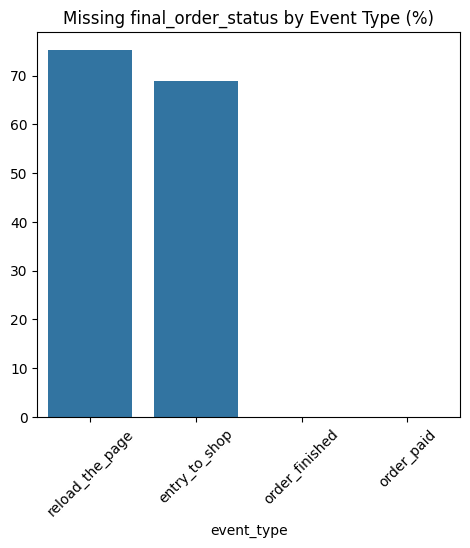

In [32]:
# Missing final_order_status by event_type
missing_by_event = df.groupby('event_type')['final_order_status'].apply(lambda x: x.isnull().mean() * 100).sort_values(ascending=False)
print("Missing final_order_status by event_type (%):\n", missing_by_event)

# Check if order completion events are missing status
order_missing = df[df['event_type'].isin(['order_paid', 'order_finished']) & df['final_order_status'].isnull()]
print(f"\nOrder events missing status: {len(order_missing)}")

# Missing shop_id analysis
print("\nMissing shop_id by event_type (%):\n", df.groupby('event_type')['shop_id'].apply(lambda x: x.isnull().mean() * 100).sort_values(ascending=False))
print("\nMissing shop_id by platform (%):\n", df.groupby('platform')['shop_id'].apply(lambda x: x.isnull().mean() * 100))
print("\nMissing shop_id by variation (%):\n", df.groupby('variation')['shop_id'].apply(lambda x: x.isnull().mean() * 100))

# Visualize relationship between missing values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=missing_by_event.index, y=missing_by_event.values)
plt.title('Missing final_order_status by Event Type (%)')
plt.xticks(rotation=45)

plt.show()

**For missing final_order_status**: This pattern makes  sense from a business perspective - early funnel events like page reloads and shop entries naturally don't have order statuses. 
It's not random and follows a structure - we will leave them as is. 

**For missing shop_id**: About 20.6% of reload_the_page events have missing shop IDs. All other event types have complete shop ID information. We could fill in the missing shop_ids based on users with mulitple events from the same session - this could deal with some of them. 

However, since the reload_page events is the only event with missing shop ids, is relatively small across platforms and variations we could just keep it as is.
The similar rates of missing values of shop_ids is a good thing:

- Android (3.43%) and iOS (3.29%)
- Variation 1 (3.42%) and Variation 2 (3.34%) 

We can test for significance here -  difference of 0.14% between platforms and 0.08% between variations.

In [33]:
# For platforms (Android vs iOS)
# Create a contingency table for missing shop_id values by platform
android_missing = df[df['platform'] == 'Android']['shop_id'].isnull().sum()
android_total = len(df[df['platform'] == 'Android'])
android_not_missing = android_total - android_missing

ios_missing = df[df['platform'] == 'iOS']['shop_id'].isnull().sum()
ios_total = len(df[df['platform'] == 'iOS'])
ios_not_missing = ios_total - ios_missing

# Create contingency table
platform_contingency = np.array([[android_missing, android_not_missing], 
                                [ios_missing, ios_not_missing]])

# Perform chi-square test
chi2, p_platform, _, _ = stats.chi2_contingency(platform_contingency)

print(f"Platform missing values comparison:")
print(f"Android: {android_missing/android_total*100:.4f}% missing")
print(f"iOS: {ios_missing/ios_total*100:.4f}% missing")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_platform:.4f}")
print(f"Statistically significant difference: {p_platform < 0.05}")

# For variations (Variation 1 vs Variation 2)
var1_missing = df[df['variation'] == 1]['shop_id'].isnull().sum()
var1_total = len(df[df['variation'] == 1])
var1_not_missing = var1_total - var1_missing

var2_missing = df[df['variation'] == 2]['shop_id'].isnull().sum()
var2_total = len(df[df['variation'] == 2])
var2_not_missing = var2_total - var2_missing

# Create contingency table
variation_contingency = np.array([[var1_missing, var1_not_missing], 
                                 [var2_missing, var2_not_missing]])

# Perform chi-square test
chi2, p_variation, _, _ = stats.chi2_contingency(variation_contingency)

print(f"\nVariation missing values comparison:")
print(f"Variation 1: {var1_missing/var1_total*100:.4f}% missing")
print(f"Variation 2: {var2_missing/var2_total*100:.4f}% missing")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_variation:.4f}")
print(f"Statistically significant difference: {p_variation < 0.05}")

Platform missing values comparison:
Android: 3.4343% missing
iOS: 3.2874% missing
Chi-square statistic: 4.5539
p-value: 0.0328
Statistically significant difference: True

Variation missing values comparison:
Variation 1: 3.4167% missing
Variation 2: 3.3372% missing
Chi-square statistic: 1.4131
p-value: 0.2345
Statistically significant difference: False


My approach here will be to seperate the ab test resulst by platform before combining them since there's statistical significance. I could impute the missing values but dont think it's worth it due to:

-  Practical difference is minimal at 0.14%. Statistical significance doesn't always mean practical significance. There's also far more android users. 

- It may be worth investigating why Android has slightly more missing shop_id values. Probably a technical reason? 

- Mising values in shop_ids doesnt change key conversion metrics, due to the missing values being top of funnel. 

### **Detect Outliers - Session Duration**

abnormal user behaviour

In [34]:
df['datetime_event'] = pd.to_datetime(df['datetime_event'])
session_data = df.groupby('session_id').agg({'datetime_event': ['min', 'max'], 'user_id': 'first', 'variation': 'first'})
session_data.head()

datetime_event                                \
                                     min                           max   
session_id                                                               
1000058    2024-11-29 18:32:58.844334422 2024-11-29 18:55:03.579241733   
1000171    2024-11-26 18:16:30.815995324 2024-11-26 18:16:30.815995324   
1000196    2024-11-30 15:48:48.603684225 2024-11-30 15:48:48.603684225   
1000206    2024-11-25 22:33:58.074592730 2024-11-25 22:33:58.074592730   
1000209    2024-11-27 19:19:34.319787366 2024-11-27 19:19:44.337119474   

           user_id variation  
             first     first  
session_id                    
1000058     142968         2  
1000171     567652         2  
1000196     254148         2  
1000206     941111         1  
1000209     605587         1

In [35]:
session_data.columns = ['start_time', 'end_time', 'user_id', 'variation']
session_data['duration_minutes'] = (session_data['end_time'] - session_data['start_time']).dt.total_seconds() / 60
session_data.head()

,start_time,end_time,user_id,variation,duration_minutes
session_id,,,,,
1000058,2024-11-29 18:32:58.844334422,2024-11-29 18:55:03.579241733,142968,2,22.078915
1000171,2024-11-26 18:16:30.815995324,2024-11-26 18:16:30.815995324,567652,2,0.000000
1000196,2024-11-30 15:48:48.603684225,2024-11-30 15:48:48.603684225,254148,2,0.000000
1000206,2024-11-25 22:33:58.074592730,2024-11-25 22:33:58.074592730,941111,1,0.000000
1000209,2024-11-27 19:19:34.319787366,2024-11-27 19:19:44.337119474,605587,1,0.166956


In [36]:
Q1 = session_data['duration_minutes'].quantile(0.25)
Q3 = session_data['duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

long_sessions = session_data[session_data['duration_minutes'] > upper_bound]

print(f"Number of unusually long sessions: {len(long_sessions)}")
print("\nStatistics for session durations (in minutes):")
print(session_data['duration_minutes'].describe())
print("\nTop 5 longest sessions:")
print(session_data.sort_values('duration_minutes', ascending=False).head())
session_data.describe(include='all').T

Number of unusually long sessions: 3360

Statistics for session durations (in minutes):
count    179294.000000
mean         10.797711
std          18.306269
min           0.000000
25%           0.000000
50%           0.000000
75%          23.846971
max         176.260608
Name: duration_minutes, dtype: float64

Top 5 longest sessions:
                              start_time                      end_time  \
session_id                                                               
7799534    2024-11-30 16:40:47.415643212 2024-11-30 19:37:03.052104168   
7547718    2024-11-30 17:12:07.467934773 2024-11-30 19:47:46.714697059   
5672583    2024-11-27 21:04:40.954634637 2024-11-27 23:36:34.991006840   
2593148    2024-11-27 23:59:22.764860307 2024-11-28 02:29:38.755541710   
7355527    2024-11-29 21:25:13.860258488 2024-11-29 23:49:08.068029540   

            user_id  variation  duration_minutes  
session_id                                        
7799534      674460          1        176.2

,count,mean,min,25%,50%,75%,max,std
start_time,179294,2024-11-28 19:37:50.664489216,2024-11-25 08:24:52.239254871,2024-11-27 16:11:14.141652224,2024-11-29 14:48:48.542581504,2024-11-29 21:39:02.095640320,2024-11-30 23:59:24,NaN
end_time,179294,2024-11-28 19:48:38.527131136,2024-11-25 09:20:42.354930277,2024-11-27 16:21:43.905405696,2024-11-29 14:57:22.301100800,2024-11-29 21:51:30.307173376,2024-12-01 01:14:56.038636271,NaN
user_id,179294.0,549906.855215,100003.0,325372.0,549021.5,775047.25,999985.0,259952.026473
variation,179294.0,1.349733,1.0,1.0,1.0,2.0,2.0,0.476887
duration_minutes,179294.0,10.797711,0.0,0.0,0.0,23.846971,176.260608,18.306269


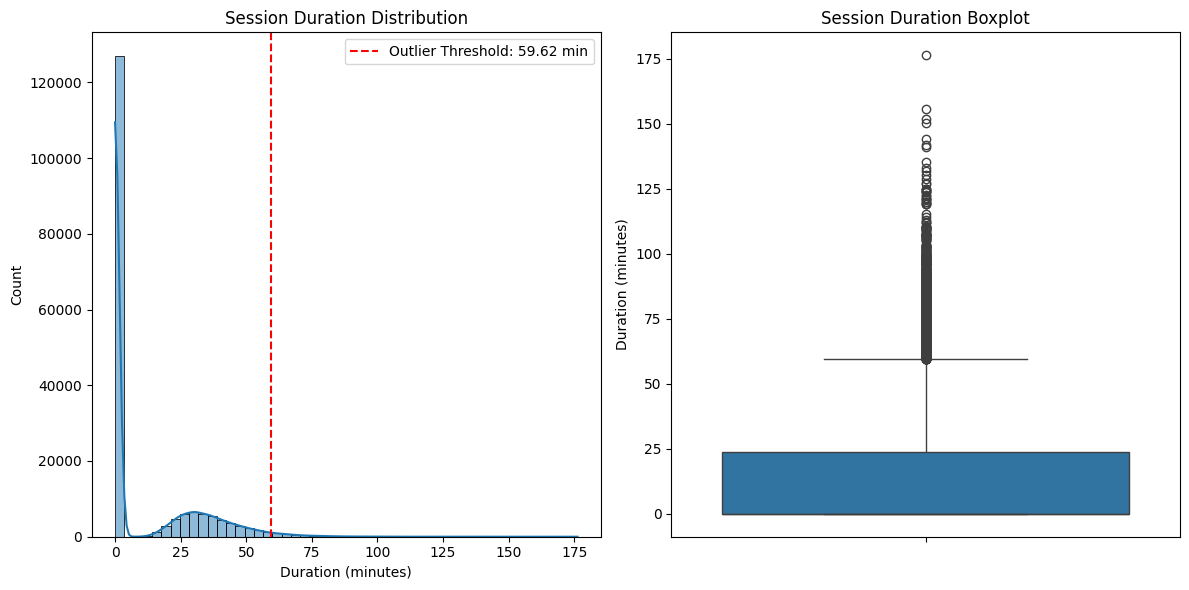

In [37]:

# Visualize session duration distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(session_data['duration_minutes'], bins=50, kde=True)
plt.title('Session Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.axvline(x=upper_bound, color='r', linestyle='--', label=f'Outlier Threshold: {upper_bound:.2f} min')
plt.legend()

plt.subplot(1, 2, 2)
sns.boxplot(y=session_data['duration_minutes'])
plt.title('Session Duration Boxplot')
plt.ylabel('Duration (minutes)')
plt.tight_layout()
plt.show()

Data Cleaning Steps

- [ ] 1. Check for Data Completeness

Verify that events are properly logged for the entire test period (Nov 25-30, 2024)
Ensure no gaps in data collection for either variation
Look for any periods of technical issues that might have affected data collection

- [ ] 2. Validate User Assignment

Confirm that users were properly randomized between control and test groups
Check if the distribution between variations is roughly equal (should be close to 50/50)
Verify that users stayed in their assigned variation throughout the test period

- [ ] 3. Identify and Handle Outliers

Look for unusual user behavior patterns (e.g., users with extremely high numbers of page reloads)
Identify and potentially exclude test accounts or internal team members
Flag sessions with technical errors that might affect normal user behavior

- [ ] 4. Session and User Data Consistency

Check for broken sessions (incomplete funnel data)
Ensure each session is properly associated with the correct user_id
Validate that the platform information (iOS/Android) is consistent within sessions

- [ ] 5. Event Sequence Validation

Verify the logical order of events (e.g., a user can't have order_paid without entry_to_shop)
Look for duplicate events within the same session
Check for proper timestamps and chronological order of events

- [x] 6. Handle Missing Values

Identify any null values in critical fields
Determine appropriate strategies for missing data (e.g., exclusion or imputation)
Check if missing values are distributed equally between test and control groups

- [] 7. Platform-Specific Issues

Check if data collection works properly across both iOS and Android
Look for platform-specific anomalies that might indicate technical issues

- [] 8. Create Analysis-Ready Dataset

Create a clean dataset that includes only valid sessions and events
Generate derived metrics for analysis (conversion rates, time between events, etc.)
Segment users appropriately for cohort analysis

### **Timestamps**

### **Create relevant KPIs**